## Linear Regression on Human Observed Dataset with Feature Concatenation


In [33]:
from sklearn.cluster import KMeans
import numpy as np
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt

In [506]:
maxAcc = 0.0
maxIter = 0
C_Lambda = 0.03 #Regularisation term for closed form
#Percentage Data Split
TrainingPercent = 80
ValidationPercent = 10
TestPercent = 10
M = 18 #Number of Basis Functions 
PHI = []
IsSynthetic = False
s=100

In [35]:
def GetTargetVector(filePath,target):
    t = []
    with open(filePath, 'rU') as f:
        reader = csv.reader(f)
        for row in reader:  
            t.append(int(row[target]))
    #print("Raw Training Generated..")
    return t

def GenerateRawData(filePath, IsSynthetic,target,s=100):    
    dataMatrix = [] 
    with open(filePath, 'rU') as fi:
        reader = csv.reader(fi)
        for row in reader:
            dataRow = []
            for column in row[0:target]:
                dataRow.append(float(column))
            dataMatrix.append(dataRow)   
    
    if IsSynthetic == True :
        if(s==0):
            dataMatrix = np.delete(dataMatrix, [450,452,456,457,962,964,968], axis=1)
        if(s==1):
            dataMatrix = np.delete(dataMatrix, [450,452,456], axis=1)
    dataMatrix = np.transpose(dataMatrix)     
    #print ("Data Matrix Generated..")
    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 80):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t

def GenerateTrainingDataMatrix(rawData, TrainingPercent = 80):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    return t

#Function to generate covariance matrix
def GenerateBigSigma(Data, MuMatrix,TrainingPercent,IsSynthetic):
    BigSigma    = np.zeros((len(Data),len(Data)))
    DataT       = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))        
    varVect     = []
    for i in range(0,len(DataT[0])):
        vct = []
        for j in range(0,int(TrainingLen)):
            vct.append(Data[i][j])    
        varVect.append(np.var(vct))
    
    for j in range(len(Data)):
        BigSigma[j][j] = varVect[j]
    if IsSynthetic == True:
        BigSigma = np.dot(3,BigSigma)
    else:
        BigSigma = np.dot(200,BigSigma)
    ##print ("BigSigma Generated..")
    return BigSigma

def GetScalar(DataRow,MuRow, BigSigInv):  
    R = np.subtract(DataRow,MuRow)
    T = np.dot(BigSigInv,np.transpose(R))  
    L = np.dot(R,T)
    return L

def GetRadialBasisOut(DataRow,MuRow, BigSigInv): #Basis function computation for data
    phi_x = math.exp(-0.5*GetScalar(DataRow,MuRow,BigSigInv))
    return phi_x


#Obtaining weights for closed form solution
def GetWeightsClosedForm(PHI, T, Lambda):
    Lambda_I = np.identity(len(PHI[0]))
    for i in range(0,len(PHI[0])):
        Lambda_I[i][i] = Lambda
    PHI_T       = np.transpose(PHI)
    PHI_SQR     = np.dot(PHI_T,PHI)
    PHI_SQR_LI  = np.add(Lambda_I,PHI_SQR)
    PHI_SQR_INV = np.linalg.inv(PHI_SQR_LI)
    INTER       = np.dot(PHI_SQR_INV, PHI_T)
    W           = np.dot(INTER, T)
    ##print ("Training Weights Generated..")
    return W

#Function to get Design Matrix PHI
def GetPhiMatrix(Data, MuMatrix, BigSigma, TrainingPercent):
    DataT = np.transpose(Data)
    TrainingLen = math.ceil(len(DataT)*(TrainingPercent*0.01))         
    PHI = np.zeros((int(TrainingLen),len(MuMatrix))) 
    BigSigInv = np.linalg.inv(BigSigma)
    for  C in range(0,len(MuMatrix)):
        for R in range(0,int(TrainingLen)):
            PHI[R][C] = GetRadialBasisOut(DataT[R], MuMatrix[C], BigSigInv)
    #print ("PHI Generated..")
    return PHI

#Validation testing with validation design matrix
def GetValTest(VAL_PHI,W):
    Y = np.dot(W,np.transpose(VAL_PHI))
    ##print ("Test Out Generated..")
    return Y

#Computing training, validation and testing ERMS
def GetErms(VAL_TEST_OUT,ValDataAct):
    sum = 0.0
    t=0
    accuracy = 0.0
    counter = 0
    val = 0.0
    for i in range (0,len(VAL_TEST_OUT)):
        sum = sum + math.pow((ValDataAct[i] - VAL_TEST_OUT[i]),2)
        if(int(np.around(VAL_TEST_OUT[i], 0)) == ValDataAct[i]):
            counter+=1
    accuracy = (float((counter*100))/float(len(VAL_TEST_OUT)))
    ##print ("Accuracy Generated..")
    ##print ("Validation E_RMS : " + str(math.sqrt(sum/len(VAL_TEST_OUT))))
    return (str(accuracy) + ',' +  str(math.sqrt(sum/len(VAL_TEST_OUT))))

### Fetch and Prepare Dataset

In [36]:
t = 18
RawTarget = GetTargetVector('final_cat.csv',t)
RawData   = GenerateRawData('final_cat.csv',IsSynthetic,t)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


### Prepare Training Data

In [37]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1265,)
(18, 1265)


### Prepare Validation Data

In [38]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = int(ValDataAct.shape[0])

(158,)
(18, 158)


### Prepare Test Data

In [39]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(157,)
(18, 157)


### Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]


In [40]:
ErmsArr = []
AccuracyArr = []
#random_state=0 is used to make randomness deterministic.
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [41]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 18)
(18, 18)
(1265, 10)
(10,)
(158, 10)
(157, 10)


### Finding Erms on training, validation and test set 


In [42]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [43]:
print ('UBITname      = anunayra')
print ('Person Number = 50291493')
print ('--------------------------------------------------------------------------')
print ("--Linear Regression on Human Observed Dataset with Feature Concatenation--")
print ('--------------------------------------------------------------------------')
print ("-------------------Closed Form with Radial Basis Function-----------------")
print ('--------------------------------------------------------------------------')
print ("M = 10 \nLambda = 0.03")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
#print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
#print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
#print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = anunayra
Person Number = 50291493
--------------------------------------------------------------------------
--Linear Regression on Human Observed Dataset with Feature Concatenation--
--------------------------------------------------------------------------
-------------------Closed Form with Radial Basis Function-----------------
--------------------------------------------------------------------------
M = 10 
Lambda = 0.03
E_rms Training   = 0.4967303666643748
E_rms Validation = 0.4936395796664404
E_rms Testing    = 0.49767401628116004


### Gradient Descent solution for Linear Regression


In [44]:
#Random initialisation of Weights   
#W_Now        = np.dot(220, W)
f = 10
W_Now        = np.zeros(f)
La           = 1.8
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,tr):
    #Weight updation process
	#print ('---------Iteration: ' + str(i) + '--------------')
	Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
	La_Delta_E_W  = np.dot(La,W_Now)
	Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
	Delta_W       = -np.dot(learningRate,Delta_E)
	W_T_Next      = W_Now + Delta_W
	W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
	TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
	Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
	L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
	VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
	Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
	L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
	TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
	Erms_Test = GetErms(TEST_OUT,TestDataAct)
	L_Erms_Test.append(float(Erms_Test.split(',')[1]))




In [45]:
print ('--------------------------------------------------------------------------')
print ("--Linear Regression on Human Observed Dataset with Feature Concatenation--")
print ('--------------------------------------------------------------------------')
print ('----------------------Gradient Descent Solution---------------------------')
print ("M = 10 \nLambda  = 1.8\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

--------------------------------------------------------------------------
--Linear Regression on Human Observed Dataset with Feature Concatenation--
--------------------------------------------------------------------------
----------------------Gradient Descent Solution---------------------------
M = 10 
Lambda  = 1.8
eta=0.01
E_rms Training   = 0.49957
E_rms Validation = 0.49914
E_rms Testing    = 0.49795


## Linear Regression on Human Observed Dataset with Feature Subtraction 


### Fetch and Prepare Dataset


In [46]:
M = 9 
t = 9
RawTarget = GetTargetVector('final_sub.csv',t)
RawData   = GenerateRawData('final_sub.csv',IsSynthetic,t)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


### Prepare Training Data

In [47]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1265,)
(9, 1265)


### Prepare Validation Data

In [48]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = ValDataAct.shape

(158,)
(9, 158)


### Prepare Test Data

In [49]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = TestDataAct.shape

(157,)
(9, 157)


### Closed Form Solution [Finding Weights using Moore- Penrose pseudo- Inverse Matrix]



In [50]:
ErmsArr = []
AccuracyArr = []
#random_state=0 is used to make randomness deterministic.
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [51]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 9)
(9, 9)
(1265, 10)
(10,)
(158, 10)
(157, 10)


### Finding Erms on training, validation and test set 



In [52]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [53]:
print ('UBITname      = anunayra')
print ('Person Number = 50291493')
print ('--------------------------------------------------------------------------')
print ("--Linear Regression on Human Observed Dataset with Feature Subtraction--")
print ('--------------------------------------------------------------------------')
print ("-------------------Closed Form with Radial Basis Function-----------------")
print ('--------------------------------------------------------------------------')
print ("M = 10 \nLambda = 0.03")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
#print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
#print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
#print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = anunayra
Person Number = 50291493
--------------------------------------------------------------------------
--Linear Regression on Human Observed Dataset with Feature Subtraction--
--------------------------------------------------------------------------
-------------------Closed Form with Radial Basis Function-----------------
--------------------------------------------------------------------------
M = 10 
Lambda = 0.03
E_rms Training   = 0.4991599889825706
E_rms Validation = 0.497113631312705
E_rms Testing    = 0.4973578173205024


### Gradient Descent solution for Linear Regression



In [54]:
#Random initialisation of Weights   
#W_Now        = np.dot(220, W)
f = 10
W_Now        = np.zeros(f)
La           = 1.8
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,tr):
    #Weight updation process
	#print ('---------Iteration: ' + str(i) + '--------------')
	Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
	La_Delta_E_W  = np.dot(La,W_Now)
	Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
	Delta_W       = -np.dot(learningRate,Delta_E)
	W_T_Next      = W_Now + Delta_W
	W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
	TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
	Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
	L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
	VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
	Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
	L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
	TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
	Erms_Test = GetErms(TEST_OUT,TestDataAct)
	L_Erms_Test.append(float(Erms_Test.split(',')[1]))



In [55]:
print ('--------------------------------------------------------------------------')
print ("--Linear Regression on Human Observed Dataset with Feature Concatenation--")
print ('--------------------------------------------------------------------------')
print ('----------------------Gradient Descent Solution---------------------------')
print ("M = 10 \nLambda  = 1.8\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

--------------------------------------------------------------------------
--Linear Regression on Human Observed Dataset with Feature Concatenation--
--------------------------------------------------------------------------
----------------------Gradient Descent Solution---------------------------
M = 10 
Lambda  = 1.8
eta=0.01
E_rms Training   = 0.50009
E_rms Validation = 0.49994
E_rms Testing    = 0.49513


## Linear Regression on GSC Dataset with Feature Concatenation 


### Fetch and Prepare Dataset



In [452]:
IsSynthetic = True
t = 1024
RawTarget = GetTargetVector('final-gsc-cat.csv',t)
RawData   = GenerateRawData('final-gsc-cat.csv',IsSynthetic,t,0)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(1017, 143062)


### Prepare Training Data

In [461]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(114450,)
(1017, 114450)


### Prepare Validation Data

In [462]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = ValDataAct.shape

(14306,)
(1017, 14306)


### Prepare Test Data

In [463]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = TestDataAct.shape

(14305,)
(1017, 14305)


In [464]:
ErmsArr = []
AccuracyArr = []
#random_state=0 is used to make randomness deterministic.
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [465]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 1017)
(1017, 1017)
(114450, 10)
(10,)
(14306, 10)
(14305, 10)


In [466]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [467]:
print ('UBITname      = anunayra')
print ('Person Number = 50291493')
print ('--------------------------------------------------------------------------')
print ("------------Linear Regression on GSC with Feature Concatenation-----------")
print ('--------------------------------------------------------------------------')
print ("-------------------Closed Form with Radial Basis Function-----------------")
print ('--------------------------------------------------------------------------')
print ("M = 10 \nLambda = 0.03")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
#print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
#print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
#print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = anunayra
Person Number = 50291493
--------------------------------------------------------------------------
------------Linear Regression on GSC with Feature Concatenation-----------
--------------------------------------------------------------------------
-------------------Closed Form with Radial Basis Function-----------------
--------------------------------------------------------------------------
M = 10 
Lambda = 0.03
E_rms Training   = 0.5070384151105187
E_rms Validation = 0.5052882346175389
E_rms Testing    = 0.506047865254507


In [468]:
f = 10
W_Now        = np.zeros(f)
La           = 1.8
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,500):
    #Weight updation process
	#print ('---------Iteration: ' + str(i) + '--------------')
	Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
	La_Delta_E_W  = np.dot(La,W_Now)
	Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
	Delta_W       = -np.dot(learningRate,Delta_E)
	W_T_Next      = W_Now + Delta_W
	W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
	TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
	Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
	L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
	VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
	Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
	L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
	TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
	Erms_Test = GetErms(TEST_OUT,TestDataAct)
	L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [469]:
print ('--------------------------------------------------------------------------')
print ("--Linear Regression on Human Observed Dataset with Feature Concatenation--")
print ('--------------------------------------------------------------------------')
print ('----------------------Gradient Descent Solution---------------------------')
print ("M = 10 \nLambda  = 1.8\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

--------------------------------------------------------------------------
--Linear Regression on Human Observed Dataset with Feature Concatenation--
--------------------------------------------------------------------------
----------------------Gradient Descent Solution---------------------------
M = 10 
Lambda  = 1.8
eta=0.01
E_rms Training   = 0.68516
E_rms Validation = 0.67824
E_rms Testing    = 0.68111


## Linear Regression on GSC Dataset with Feature Subtraction



### Fetch and Prepare Dataset



In [470]:
IsSynthetic = True
t = 512
RawTarget = GetTargetVector('final-gsc-sub.csv',t)
RawData   = GenerateRawData('final-gsc-sub.csv',IsSynthetic,t,1)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(509, 143062)


### Prepare Training Data

In [471]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(114450,)
(509, 114450)


### Prepare Validation Data


In [472]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = ValDataAct.shape

(14306,)
(509, 14306)


### Prepare Test Data


In [473]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = TestDataAct.shape

(14305,)
(509, 14305)


In [474]:
ErmsArr = []
AccuracyArr = []
#random_state=0 is used to make randomness deterministic.
kmeans = KMeans(n_clusters=M, random_state=0).fit(np.transpose(TrainingData))
Mu = kmeans.cluster_centers_

BigSigma     = GenerateBigSigma(RawData, Mu, TrainingPercent,IsSynthetic)
TRAINING_PHI = GetPhiMatrix(RawData, Mu, BigSigma, TrainingPercent)
W            = GetWeightsClosedForm(TRAINING_PHI,TrainingTarget,(C_Lambda)) 
TEST_PHI     = GetPhiMatrix(TestData, Mu, BigSigma, 100) 
VAL_PHI      = GetPhiMatrix(ValData, Mu, BigSigma, 100)

In [475]:
print(Mu.shape)
print(BigSigma.shape)
print(TRAINING_PHI.shape)
print(W.shape)
print(VAL_PHI.shape)
print(TEST_PHI.shape)

(10, 509)
(509, 509)
(114450, 10)
(10,)
(14306, 10)
(14305, 10)


In [476]:
TR_TEST_OUT  = GetValTest(TRAINING_PHI,W)
VAL_TEST_OUT = GetValTest(VAL_PHI,W)
TEST_OUT     = GetValTest(TEST_PHI,W)

TrainingAccuracy   = str(GetErms(TR_TEST_OUT,TrainingTarget))
ValidationAccuracy = str(GetErms(VAL_TEST_OUT,ValDataAct))
TestAccuracy       = str(GetErms(TEST_OUT,TestDataAct))

In [477]:
print ('UBITname      = anunayra')
print ('Person Number = 50291493')
print ('--------------------------------------------------------------------------')
print ("------------Linear Regression on GSC with Feature Subtraction-------------")
print ('--------------------------------------------------------------------------')
print ("-------------------Closed Form with Radial Basis Function-----------------")
print ('--------------------------------------------------------------------------')
print ("M = 10 \nLambda = 0.03")
print ("E_rms Training   = " + str(float(TrainingAccuracy.split(',')[1])))
print ("E_rms Validation = " + str(float(ValidationAccuracy.split(',')[1])))
print ("E_rms Testing    = " + str(float(TestAccuracy.split(',')[1])))
#print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
#print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
#print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

UBITname      = anunayra
Person Number = 50291493
--------------------------------------------------------------------------
------------Linear Regression on GSC with Feature Subtraction-------------
--------------------------------------------------------------------------
-------------------Closed Form with Radial Basis Function-----------------
--------------------------------------------------------------------------
M = 10 
Lambda = 0.03
E_rms Training   = 0.7082241711685279
E_rms Validation = 0.7010008622415624
E_rms Testing    = 0.704159509748694


In [478]:
f = 10
W_Now        = np.zeros(f)
La           = 1.8
learningRate = 0.01
L_Erms_Val   = []
L_Erms_TR    = []
L_Erms_Test  = []
W_Mat        = []

for i in range(0,500):
    #Weight updation process
	#print ('---------Iteration: ' + str(i) + '--------------')
	Delta_E_D     = -np.dot((TrainingTarget[i] - np.dot(np.transpose(W_Now),TRAINING_PHI[i])),TRAINING_PHI[i])
	La_Delta_E_W  = np.dot(La,W_Now)
	Delta_E       = np.add(Delta_E_D,La_Delta_E_W)    
	Delta_W       = -np.dot(learningRate,Delta_E)
	W_T_Next      = W_Now + Delta_W
	W_Now         = W_T_Next
    
    #-----------------TrainingData Accuracy---------------------#
	TR_TEST_OUT   = GetValTest(TRAINING_PHI,W_T_Next) 
	Erms_TR       = GetErms(TR_TEST_OUT,TrainingTarget)
	L_Erms_TR.append(float(Erms_TR.split(',')[1]))
    
    #-----------------ValidationData Accuracy---------------------#
	VAL_TEST_OUT  = GetValTest(VAL_PHI,W_T_Next) 
	Erms_Val      = GetErms(VAL_TEST_OUT,ValDataAct)
	L_Erms_Val.append(float(Erms_Val.split(',')[1]))
    
    #-----------------TestingData Accuracy---------------------#
	TEST_OUT      = GetValTest(TEST_PHI,W_T_Next) 
	Erms_Test = GetErms(TEST_OUT,TestDataAct)
	L_Erms_Test.append(float(Erms_Test.split(',')[1]))

In [479]:
print ('--------------------------------------------------------------------------')
print ("--------Linear Regression on GSC Dataset with Feature Subtraction---------")
print ('--------------------------------------------------------------------------')
print ('----------------------Gradient Descent Solution---------------------------')
print ("M = 10 \nLambda  = 1.8\neta=0.01")
print ("E_rms Training   = " + str(np.around(min(L_Erms_TR),5)))
print ("E_rms Validation = " + str(np.around(min(L_Erms_Val),5)))
print ("E_rms Testing    = " + str(np.around(min(L_Erms_Test),5)))

--------------------------------------------------------------------------
--------Linear Regression on GSC Dataset with Feature Subtraction---------
--------------------------------------------------------------------------
----------------------Gradient Descent Solution---------------------------
M = 10 
Lambda  = 1.8
eta=0.01
E_rms Training   = 0.70822
E_rms Validation = 0.701
E_rms Testing    = 0.70416


## Logistic Regression on Human Observed Dataset with Feature Concatenation

### Fetch and Prepare Dataset



In [169]:
IsSynthetic = False
t = 18
RawTarget = GetTargetVector('final_cat.csv',t)
RawData   = GenerateRawData('final_cat.csv',IsSynthetic,t)
print(RawData.shape)

(18, 1581)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


### Prepare Training Data


In [170]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1265,)
(18, 1265)


### Prepare Validation Data



In [171]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = int(ValDataAct.shape[0])

(158,)
(18, 158)


### Prepare Test Data

In [172]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(157,)
(18, 157)


In [173]:
# Initialize weights and bias as zero.
W_now        = np.zeros(t)
b = 0 
TrainingData = np.transpose(TrainingData)
ValData = np.transpose(ValData)
TestData = np.transpose(TestData)

In [174]:
for j in range(0,tr):
	z = (np.dot(W_now,TrainingData[j]) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	W_next = W_now - learningRate*np.dot((a - TrainingTarget[j]), TrainingData[j])
	W_now = W_next
	b = b - learningRate*(a - TrainingTarget[j])

In [175]:
#Training Accuracy
predict = []
for i in range(0,v):
	z = (np.dot((W_now),(TrainingData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TrainingAccuracy   = str(GetErms(predict,TrainingTarget))


In [178]:

predict = []
for i in range(0,v):
	z = (np.dot((W_now),(ValData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
ValidationAccuracy = str(GetErms(predict,ValDataAct))


In [179]:

predict = []
for i in range(0,te):
	z = (np.dot((W_now),(ValData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TestAccuracy       = str(GetErms(predict,TestDataAct))

In [180]:
print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

Training Accuracy   = 56.962025316455694
Validation Accuracy = 55.69620253164557
Testing Accuracy    = 45.859872611464965


## Logistic Regression on Human Observed Dataset with Feature Subtraction


### Fetch and Prepare Dataset



In [507]:
IsSynthetic = False
t = 9
RawTarget = GetTargetVector('final_sub.csv',t)
RawData   = GenerateRawData('final_sub.csv',IsSynthetic,t)
print(RawData.shape)

(9, 1581)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


### Prepare Training Data



In [508]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1265,)
(9, 1265)


### Prepare Validation Data

In [509]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = int(ValDataAct.shape[0])

(158,)
(9, 158)


### Prepare Test Data

In [510]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(157,)
(9, 157)


In [511]:
# Initialize weights and bias as zero.
W_now        = np.zeros(t)
b = 0 
TrainingData = np.transpose(TrainingData)
ValData = np.transpose(ValData)
TestData = np.transpose(TestData)

In [512]:
for j in range(0,tr):
	z = (np.dot((W_now),(TrainingData[j])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	W_next = W_now - learningRate*np.dot((a - TrainingTarget[j]), TrainingData[j])
	W_now = W_next
	b = b - learningRate*(a - TrainingTarget[j])

In [513]:
#Training Accuracy
predict = []
for i in range(0,tr):
	z = (np.dot((W_now),(TrainingData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TrainingAccuracy   = str(GetErms(predict,TrainingTarget))

In [514]:
predict = []
for i in range(0,v):
	z = (np.dot((W_now),(ValData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
ValidationAccuracy = str(GetErms(predict,ValDataAct))

In [515]:
predict = []
for i in range(0,te):
	z = (np.dot((W_now),(TestData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TestAccuracy       = str(GetErms(predict,TestDataAct))

In [516]:
print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

Training Accuracy   = 49.32806324110672
Validation Accuracy = 51.265822784810126
Testing Accuracy    = 54.140127388535035


## Logistic Regression on GSC Dataset with Feature Concatenation



### Fetch and Prepare Dataset




In [313]:
IsSynthetic = False
t = 1024
RawTarget = GetTargetVector('final-gsc-cat.csv',t)
RawData   = GenerateRawData('final-gsc-cat.csv',IsSynthetic,t)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(1024, 143062)


### Prepare Training Data



In [314]:
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(114450,)
(1024, 114450)


### Prepare Validation Data


In [315]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = int(ValDataAct.shape[0])

(14306,)
(1024, 14306)


### Prepare Test Data


In [316]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(14305,)
(1024, 14305)


In [317]:
# Initialize weights and bias as zero.
W_now        = np.zeros(t)
b = 0 
TrainingData = np.transpose(TrainingData)
ValData = np.transpose(ValData)
TestData = np.transpose(TestData)

In [318]:
for j in range(0,tr):
	z = (np.dot((W_now),(TrainingData[j])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	W_next = W_now - learningRate*np.dot((a - TrainingTarget[j]), TrainingData[j])
	W_now = W_next
	b = b - learningRate*(a - TrainingTarget[j])

In [319]:
#Training Accuracy
predict = []
for i in range(0,tr):
	z = (np.dot((W_now),(TrainingData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)

TrainingAccuracy   = str(GetErms(predict,TrainingTarget))

In [320]:
predict = []

for i in range(0,v):
	z = (np.dot((W_now),(ValData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
ValidationAccuracy = str(GetErms(predict,ValDataAct))

In [321]:
predict = []
for i in range(0,te):
	z = (np.dot((W_now),(TestData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TestAccuracy       = str(GetErms(predict,TestDataAct))

In [327]:
print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

Training Accuracy   = 55.83049366535605
Validation Accuracy = 54.65538934712708
Testing Accuracy    = 54.771059070255156


## Logistic Regression on GSC Dataset with Feature Subtraction



### Fetch and Prepare Dataset



In [328]:

IsSynthetic = False
t = 512
RawTarget = GetTargetVector('final-gsc-sub.csv',t)
RawData   = GenerateRawData('final-gsc-sub.csv',IsSynthetic,t)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(512, 143062)


### Prepare Training Data



In [329]:

TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(114450,)
(512, 114450)


### Prepare Validation Data



In [330]:
ValDataAct = np.array(GenerateValTargetVector(RawTarget,ValidationPercent, (len(TrainingTarget))))
ValData    = GenerateValData(RawData,ValidationPercent, (len(TrainingTarget)))
print(ValDataAct.shape)
print(ValData.shape)
v = int(ValDataAct.shape[0])

(14306,)
(512, 14306)


### Prepare Test Data



In [331]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget)+len(ValDataAct))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)+len(ValDataAct)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(14305,)
(512, 14305)


In [332]:
# Initialize weights and bias as zero.
W_now        = np.zeros(t)
b = 0 
TrainingData = np.transpose(TrainingData)
ValData = np.transpose(ValData)
TestData = np.transpose(TestData)

In [333]:
for j in range(0,tr):
	z = (np.dot((W_now),(TrainingData[j])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	W_next = W_now - learningRate*np.dot((a - TrainingTarget[j]), TrainingData[j])
	W_now = W_next
	b = b - learningRate*(a - TrainingTarget[j])

In [334]:
#Training Accuracy
predict = []
for i in range(0,tr):
	z = (np.dot((W_now),(TrainingData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)

TrainingAccuracy   = str(GetErms(predict,TrainingTarget))

In [335]:

predict = []

for i in range(0,v):
	z = (np.dot((W_now),(ValData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
ValidationAccuracy = str(GetErms(predict,ValDataAct))

In [336]:

predict = []
for i in range(0,te):
	z = (np.dot((W_now),(TestData[i])) + b )
	a = 1.0 / (1.0 + math.exp(-z))
	predict.append(a)
TestAccuracy       = str(GetErms(predict,TestDataAct))

In [337]:
print ("Training Accuracy   = " + str(float(TrainingAccuracy.split(',')[0])))
print ("Validation Accuracy = " + str(float(ValidationAccuracy.split(',')[0])))
print ("Testing Accuracy    = " + str(float(TestAccuracy.split(',')[0])))

Training Accuracy   = 77.25993883792049
Validation Accuracy = 76.69509296798546
Testing Accuracy    = 76.77735057672143


## Neural Network on Human Observed Dataset with Feature Concatenation

### Fetch and Prepare Dataset

In [338]:

IsSynthetic = False
t = 18
RawTarget = GetTargetVector('final_cat.csv',t)
RawData   = GenerateRawData('final_cat.csv',IsSynthetic,t)
print(RawData.shape)

(18, 1581)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


### Prepare Training and Validation Data



In [339]:
TrainingPercent = 90
# Validation Percent will be 10% of the TrainingPercent
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1423,)
(18, 1423)


### Prepare Test Data

In [340]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(157,)
(18, 157)


### Model Defination

In [341]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
import pandas as pd
import numpy as np

input_size = 18
drop_out = 0.2
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 1

def get_model():
    
   
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    
    #model.add(Dense(1))
    #model.add(Activation('sigmoid'))
    model.summary()
    

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Creating Model

In [342]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               4864      
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [344]:
validation_data_split = 0.1
num_epochs = 10000
model_batch_size = 128
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
TrainingData = np.transpose(TrainingData)
TestData = np.transpose(TestData)
# Process Dataset
processedData, processedLabel = TrainingData, TrainingTarget
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 1280 samples, validate on 143 samples
Epoch 1/10000
1280/1280 [==============================] - 0s 363us/step - loss: 0.7143 - acc: 0.5227 - val_loss: 0.6921 - val_acc: 0.5105
Epoch 2/10000
1280/1280 [==============================] - 0s 38us/step - loss: 0.7105 - acc: 0.5234 - val_loss: 0.6831 - val_acc: 0.5455
Epoch 3/10000
1280/1280 [==============================] - 0s 50us/step - loss: 0.6902 - acc: 0.5445 - val_loss: 0.6816 - val_acc: 0.5524
Epoch 4/10000
1280/1280 [==============================] - 0s 39us/step - loss: 0.6896 - acc: 0.5430 - val_loss: 0.6830 - val_acc: 0.5734
Epoch 5/10000
1280/1280 [==============================] - 0s 25us/step - loss: 0.6903 - acc: 0.5438 - val_loss: 0.6822 - val_acc: 0.5664
Epoch 6/10000
1280/1280 [==============================] - 0s 53us/step - loss: 0.6952 - acc: 0.5391 - val_loss: 0.6845 - val_acc: 0.5524
Epoch 7/10000
1280/1280 [==============================] - 0s 28us/step - loss: 0.6891 - acc: 0.5461 - val_loss: 0.6853 - va

1280/1280 [==============================] - 0s 26us/step - loss: 0.6362 - acc: 0.6234 - val_loss: 0.6889 - val_acc: 0.5175
Epoch 60/10000
1280/1280 [==============================] - 0s 24us/step - loss: 0.6272 - acc: 0.6586 - val_loss: 0.6877 - val_acc: 0.5455
Epoch 61/10000
1280/1280 [==============================] - 0s 29us/step - loss: 0.6300 - acc: 0.6648 - val_loss: 0.6928 - val_acc: 0.5664
Epoch 62/10000
1280/1280 [==============================] - 0s 32us/step - loss: 0.6222 - acc: 0.6703 - val_loss: 0.6871 - val_acc: 0.5315
Epoch 63/10000
1280/1280 [==============================] - 0s 29us/step - loss: 0.6265 - acc: 0.6664 - val_loss: 0.6873 - val_acc: 0.5315
Epoch 64/10000
1280/1280 [==============================] - 0s 23us/step - loss: 0.6255 - acc: 0.6695 - val_loss: 0.6967 - val_acc: 0.5594
Epoch 65/10000
1280/1280 [==============================] - 0s 23us/step - loss: 0.6211 - acc: 0.6531 - val_loss: 0.6897 - val_acc: 0.5105
Epoch 66/10000
1280/1280 [================

Epoch 118/10000
1280/1280 [==============================] - 0s 24us/step - loss: 0.5639 - acc: 0.7180 - val_loss: 0.7065 - val_acc: 0.5455
Epoch 119/10000
1280/1280 [==============================] - 0s 22us/step - loss: 0.5540 - acc: 0.7422 - val_loss: 0.7136 - val_acc: 0.5105
Epoch 120/10000
1280/1280 [==============================] - 0s 20us/step - loss: 0.5582 - acc: 0.7359 - val_loss: 0.7344 - val_acc: 0.5385
Epoch 121/10000
1280/1280 [==============================] - 0s 21us/step - loss: 0.5552 - acc: 0.7258 - val_loss: 0.7172 - val_acc: 0.5175
Epoch 122/10000
1280/1280 [==============================] - 0s 23us/step - loss: 0.5594 - acc: 0.7344 - val_loss: 0.7107 - val_acc: 0.5455
Epoch 123/10000
1280/1280 [==============================] - 0s 19us/step - loss: 0.5615 - acc: 0.7172 - val_loss: 0.7097 - val_acc: 0.5524
Epoch 124/10000
1280/1280 [==============================] - 0s 23us/step - loss: 0.5621 - acc: 0.7297 - val_loss: 0.7100 - val_acc: 0.5175
Epoch 00124: early s

### Training and Validation Graphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3752ae80>,
      dtype=object)

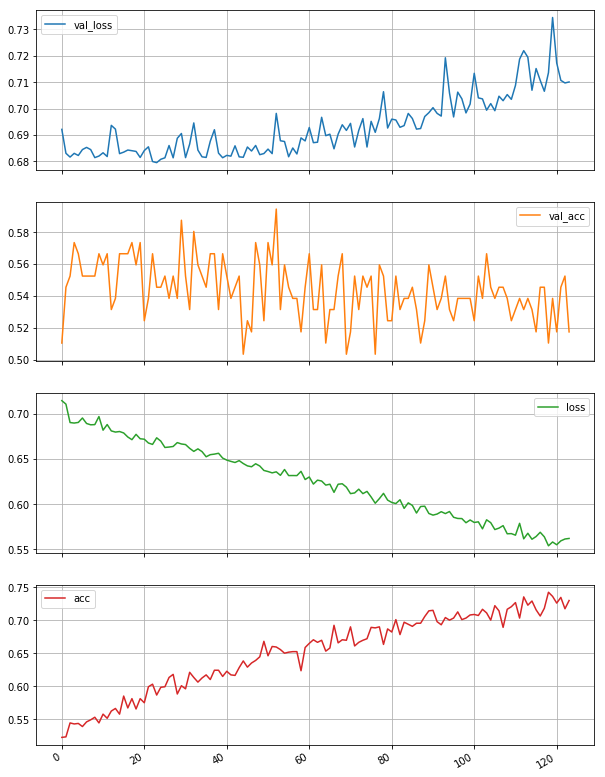

In [347]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Testing Accuracy

In [355]:
y = model.predict(TestData)
y = np.around(y)

In [360]:
correct = 0
wrong   = 0
j = 0
for i in TestDataAct:
    if y[j]==i:
        correct = correct + 1
        j = j + 1
    else:
        wrong = wrong + 1
        j = j + 1

In [364]:
print("Errors: " + str(wrong), " Correct :" + str(correct))

print("Testing Accuracy: " + str(correct/(correct+wrong)*100))

Errors: 66  Correct :91
Testing Accuracy: 57.961783439490446


## Neural Network on Human Observed Dataset with Feature Subtraction

### Fetch and Prepare Dataset


In [412]:
IsSynthetic = False
t = 9
RawTarget = GetTargetVector('final1600sub.csv',t)
RawData   = GenerateRawData('final1600sub.csv',IsSynthetic,t)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(9, 1583)


### Prepare Training and Validation Data



In [413]:
TrainingPercent = 90
# Validation Percent will be 10% of the TrainingPercent
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(1425,)
(9, 1425)


### Prepare Test Data

In [414]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(157,)
(9, 157)


### Model Definition

In [415]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
import pandas as pd
import numpy as np

input_size = 9
drop_out = 0.2
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 1

def get_model():
    
   
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    
    #model.add(Dense(1))
    #model.add(Activation('sigmoid'))
    model.summary()
    

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Creating Model

In [416]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2560      
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [417]:
validation_data_split = 0.1
num_epochs = 10000
model_batch_size = 128
tb_batch_size = 32
early_patience = 100

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
TrainingData = np.transpose(TrainingData)
TestData = np.transpose(TestData)
# Process Dataset
processedData, processedLabel = TrainingData, TrainingTarget
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 1282 samples, validate on 143 samples
Epoch 1/10000
1282/1282 [==============================] - 0s 290us/step - loss: 0.5876 - acc: 0.7293 - val_loss: 0.5003 - val_acc: 0.8042
Epoch 2/10000
1282/1282 [==============================] - 0s 23us/step - loss: 0.4591 - acc: 0.8370 - val_loss: 0.4046 - val_acc: 0.8951
Epoch 3/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.3923 - acc: 0.8752 - val_loss: 0.3646 - val_acc: 0.8951
Epoch 4/10000
1282/1282 [==============================] - 0s 26us/step - loss: 0.3444 - acc: 0.8814 - val_loss: 0.3356 - val_acc: 0.8881
Epoch 5/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.3136 - acc: 0.8822 - val_loss: 0.3007 - val_acc: 0.9161
Epoch 6/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.2922 - acc: 0.8885 - val_loss: 0.3017 - val_acc: 0.9091
Epoch 7/10000
1282/1282 [==============================] - 0s 28us/step - loss: 0.2775 - acc: 0.8892 - val_loss: 0.2797 - va

1282/1282 [==============================] - 0s 18us/step - loss: 0.1787 - acc: 0.9282 - val_loss: 0.2278 - val_acc: 0.9161
Epoch 60/10000
1282/1282 [==============================] - 0s 15us/step - loss: 0.1807 - acc: 0.9321 - val_loss: 0.2259 - val_acc: 0.9161
Epoch 61/10000
1282/1282 [==============================] - 0s 15us/step - loss: 0.1800 - acc: 0.9345 - val_loss: 0.2243 - val_acc: 0.9161
Epoch 62/10000
1282/1282 [==============================] - 0s 17us/step - loss: 0.1805 - acc: 0.9306 - val_loss: 0.2187 - val_acc: 0.9091
Epoch 63/10000
1282/1282 [==============================] - 0s 18us/step - loss: 0.1811 - acc: 0.9306 - val_loss: 0.2438 - val_acc: 0.9231
Epoch 64/10000
1282/1282 [==============================] - 0s 15us/step - loss: 0.1815 - acc: 0.9306 - val_loss: 0.2353 - val_acc: 0.9231
Epoch 65/10000
1282/1282 [==============================] - 0s 16us/step - loss: 0.1800 - acc: 0.9314 - val_loss: 0.2252 - val_acc: 0.9161
Epoch 66/10000
1282/1282 [================

1282/1282 [==============================] - 0s 18us/step - loss: 0.1454 - acc: 0.9415 - val_loss: 0.1916 - val_acc: 0.9371
Epoch 118/10000
1282/1282 [==============================] - 0s 15us/step - loss: 0.1452 - acc: 0.9438 - val_loss: 0.1935 - val_acc: 0.9371
Epoch 119/10000
1282/1282 [==============================] - 0s 19us/step - loss: 0.1473 - acc: 0.9462 - val_loss: 0.1937 - val_acc: 0.9371
Epoch 120/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.1458 - acc: 0.9446 - val_loss: 0.1987 - val_acc: 0.9371
Epoch 121/10000
1282/1282 [==============================] - 0s 18us/step - loss: 0.1443 - acc: 0.9438 - val_loss: 0.1885 - val_acc: 0.9371
Epoch 122/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.1456 - acc: 0.9485 - val_loss: 0.1812 - val_acc: 0.9371
Epoch 123/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.1408 - acc: 0.9509 - val_loss: 0.1824 - val_acc: 0.9371
Epoch 124/10000
1282/1282 [=========

1282/1282 [==============================] - 0s 20us/step - loss: 0.1268 - acc: 0.9485 - val_loss: 0.1859 - val_acc: 0.9441
Epoch 176/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.1220 - acc: 0.9501 - val_loss: 0.1721 - val_acc: 0.9371
Epoch 177/10000
1282/1282 [==============================] - 0s 22us/step - loss: 0.1270 - acc: 0.9509 - val_loss: 0.1765 - val_acc: 0.9441
Epoch 178/10000
1282/1282 [==============================] - 0s 16us/step - loss: 0.1272 - acc: 0.9532 - val_loss: 0.1724 - val_acc: 0.9371
Epoch 179/10000
1282/1282 [==============================] - 0s 17us/step - loss: 0.1249 - acc: 0.9524 - val_loss: 0.1736 - val_acc: 0.9441
Epoch 180/10000
1282/1282 [==============================] - 0s 17us/step - loss: 0.1215 - acc: 0.9485 - val_loss: 0.1821 - val_acc: 0.9441
Epoch 181/10000
1282/1282 [==============================] - 0s 19us/step - loss: 0.1232 - acc: 0.9540 - val_loss: 0.1733 - val_acc: 0.9441
Epoch 182/10000
1282/1282 [=========

1282/1282 [==============================] - 0s 19us/step - loss: 0.1164 - acc: 0.9563 - val_loss: 0.1736 - val_acc: 0.9441
Epoch 234/10000
1282/1282 [==============================] - 0s 19us/step - loss: 0.1088 - acc: 0.9618 - val_loss: 0.1681 - val_acc: 0.9441
Epoch 235/10000
1282/1282 [==============================] - 0s 32us/step - loss: 0.1115 - acc: 0.9618 - val_loss: 0.1864 - val_acc: 0.9441
Epoch 236/10000
1282/1282 [==============================] - 0s 22us/step - loss: 0.1104 - acc: 0.9571 - val_loss: 0.1751 - val_acc: 0.9441
Epoch 237/10000
1282/1282 [==============================] - 0s 21us/step - loss: 0.1117 - acc: 0.9563 - val_loss: 0.1851 - val_acc: 0.9441
Epoch 238/10000
1282/1282 [==============================] - 0s 21us/step - loss: 0.1101 - acc: 0.9579 - val_loss: 0.1754 - val_acc: 0.9441
Epoch 239/10000
1282/1282 [==============================] - 0s 23us/step - loss: 0.1118 - acc: 0.9524 - val_loss: 0.1822 - val_acc: 0.9441
Epoch 240/10000
1282/1282 [=========

1282/1282 [==============================] - 0s 19us/step - loss: 0.0995 - acc: 0.9626 - val_loss: 0.1703 - val_acc: 0.9441
Epoch 292/10000
1282/1282 [==============================] - 0s 19us/step - loss: 0.0957 - acc: 0.9602 - val_loss: 0.1837 - val_acc: 0.9371
Epoch 293/10000
1282/1282 [==============================] - 0s 21us/step - loss: 0.1018 - acc: 0.9626 - val_loss: 0.1781 - val_acc: 0.9441
Epoch 294/10000
1282/1282 [==============================] - 0s 24us/step - loss: 0.1001 - acc: 0.9594 - val_loss: 0.1766 - val_acc: 0.9441
Epoch 295/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.0989 - acc: 0.9594 - val_loss: 0.1958 - val_acc: 0.9371
Epoch 296/10000
1282/1282 [==============================] - 0s 23us/step - loss: 0.1014 - acc: 0.9626 - val_loss: 0.1814 - val_acc: 0.9441
Epoch 297/10000
1282/1282 [==============================] - 0s 20us/step - loss: 0.1045 - acc: 0.9602 - val_loss: 0.1811 - val_acc: 0.9441
Epoch 298/10000
1282/1282 [=========

### Training and Validation Graphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a380b9b00>,
      dtype=object)

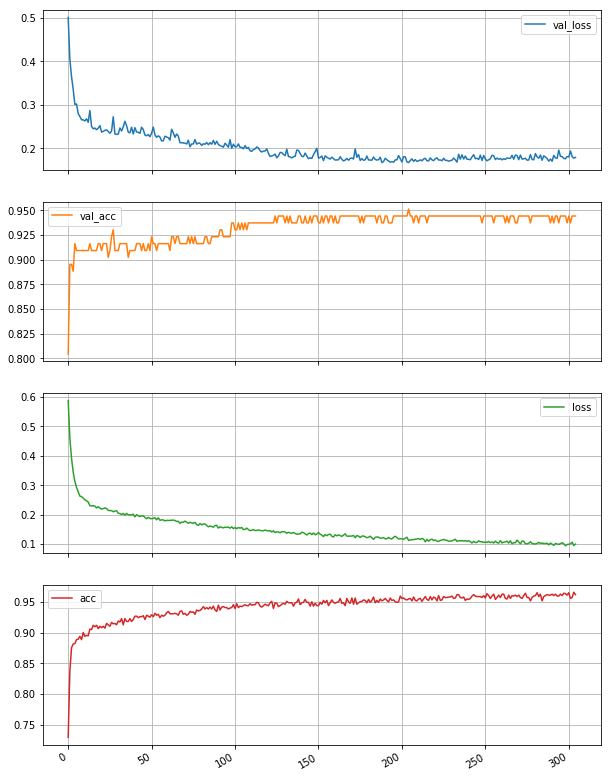

In [418]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Testing Accuracy

In [419]:
y = model.predict(TestData)
y = np.around(y)
correct = 0
wrong   = 0
j = 0
for i in TestDataAct:
    if y[j]==i:
        correct = correct + 1
        j = j + 1
    else:
        wrong = wrong + 1
        j = j + 1
print("Errors: " + str(wrong), " Correct :" + str(correct))

print("Testing Accuracy: " + str(correct/(correct+wrong)*100))

Errors: 19  Correct :138
Testing Accuracy: 87.89808917197452


## Neural Network on GSC Dataset with Feature Concatenation

### Fetch and Prepare Dataset



In [480]:
IsSynthetic = False
t = 1024
RawTarget = GetTargetVector('final-gsc-cat.csv',t)
RawData   = GenerateRawData('final-gsc-cat.csv',IsSynthetic,t)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(1024, 143062)


### Prepare Training and Validation Data



In [481]:
TrainingPercent = 90
# Validation Percent will be 10% of the TrainingPercent
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(128756,)
(1024, 128756)


### Prepare Test Data

In [482]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(14305,)
(1024, 14305)


### Model Definition


In [483]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
import pandas as pd
import numpy as np

input_size = 1024
drop_out = 0.2
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 1

def get_model():
    
   
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    
    #model.add(Dense(1))
    #model.add(Activation('sigmoid'))
    model.summary()
    

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Creating Model

In [484]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
_________________________________________________________________
activation_18 (Activation)   (None, 1)                 0         
Total params: 525,313
Trainable params: 525,313
Non-trainable params: 0
_________________________________________________________________


In [485]:
validation_data_split = 0.1
num_epochs = 30
model_batch_size = 128
tb_batch_size = 32
early_patience = 10

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
TrainingData = np.transpose(TrainingData)
TestData = np.transpose(TestData)
# Process Dataset
processedData, processedLabel = TrainingData, TrainingTarget
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 115880 samples, validate on 12876 samples
Epoch 1/30
115880/115880 [==============================] - 19s 161us/step - loss: 0.4833 - acc: 0.7618 - val_loss: 0.3825 - val_acc: 0.8267
Epoch 2/30
115880/115880 [==============================] - 12s 102us/step - loss: 0.3164 - acc: 0.8624 - val_loss: 0.3240 - val_acc: 0.8468
Epoch 3/30
115880/115880 [==============================] - 15s 131us/step - loss: 0.2349 - acc: 0.9021 - val_loss: 0.2545 - val_acc: 0.8891
Epoch 4/30
115880/115880 [==============================] - 15s 128us/step - loss: 0.1810 - acc: 0.9261 - val_loss: 0.2197 - val_acc: 0.9047
Epoch 5/30
115880/115880 [==============================] - 12s 104us/step - loss: 0.1479 - acc: 0.9411 - val_loss: 0.2158 - val_acc: 0.9195
Epoch 6/30
115880/115880 [==============================] - 14s 124us/step - loss: 0.1221 - acc: 0.9518 - val_loss: 0.2232 - val_acc: 0.9115
Epoch 7/30
115880/115880 [==============================] - 14s 119us/step - loss: 0.1019 - acc: 0.9605

### Training and Validation Graphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a39851c50>,
      dtype=object)

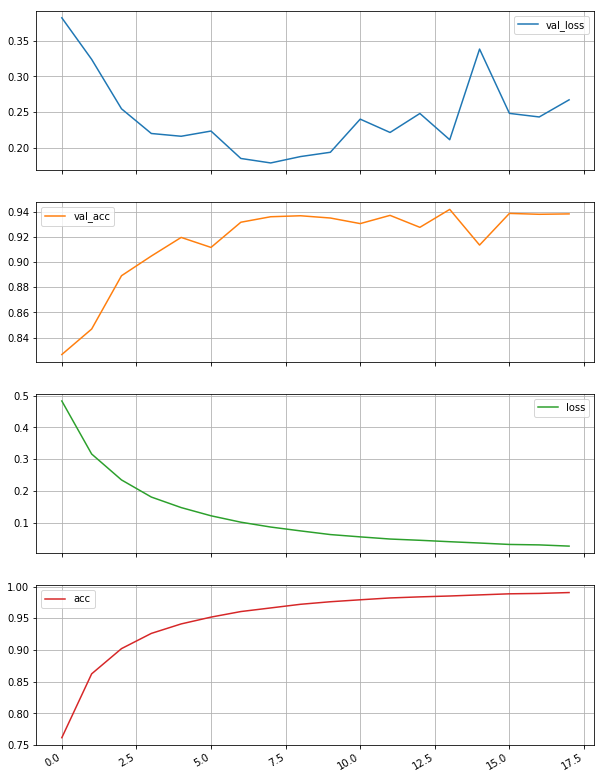

In [486]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Testing Accuracy

In [487]:
y = model.predict(TestData)
y = np.around(y)
correct = 0
wrong   = 0
j = 0
for i in TestDataAct:
    if y[j]==i:
        correct = correct + 1
        j = j + 1
    else:
        wrong = wrong + 1
        j = j + 1
print("Errors: " + str(wrong), " Correct :" + str(correct))

print("Testing Accuracy: " + str(correct/(correct+wrong)*100))

Errors: 866  Correct :13439
Testing Accuracy: 93.94617266689968


## Neural Network on GSC Dataset with Feature Subtraction


### Fetch and Prepare Dataset

In [488]:
IsSynthetic = False
t = 512
RawTarget = GetTargetVector('final-gsc-sub.csv',t)
RawData   = GenerateRawData('final-gsc-sub.csv',IsSynthetic,t)
print(RawData.shape)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 'U' mode is deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


(512, 143062)


### Prepare Training and Validation Dataset




In [489]:
TrainingPercent = 90
# Validation Percent will be 10% of the TrainingPercent
TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
print(TrainingTarget.shape)
print(TrainingData.shape)
tr = int(TrainingTarget.shape[0])

(128756,)
(512, 128756)


### Prepare Test Dataset




In [490]:
TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget))))
TestData = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
print(TestDataAct.shape)
print(TestData.shape)
te = int(TestDataAct.shape[0])

(14305,)
(512, 14305)


### Model Definition



In [491]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
import pandas as pd
import numpy as np

input_size = 512
drop_out = 0.2
first_dense_layer_nodes  = 256
second_dense_layer_nodes = 1

def get_model():
    
   
    model = Sequential()
    
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))
    
  
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes))
    model.add(Activation('sigmoid'))
    
    #model.add(Dense(1))
    #model.add(Activation('sigmoid'))
    model.summary()
    

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Create Model

In [492]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_19 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 257       
_________________________________________________________________
activation_20 (Activation)   (None, 1)                 0         
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [493]:
validation_data_split = 0.1
num_epochs = 50
model_batch_size = 128
tb_batch_size = 32
early_patience = 10

tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')
TrainingData = np.transpose(TrainingData)
TestData = np.transpose(TestData)
# Process Dataset
processedData, processedLabel = TrainingData, TrainingTarget
history = model.fit(processedData
                    , processedLabel
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )

Train on 115880 samples, validate on 12876 samples
Epoch 1/50
115880/115880 [==============================] - 7s 62us/step - loss: 0.4832 - acc: 0.7656 - val_loss: 0.4072 - val_acc: 0.8173
Epoch 2/50
115880/115880 [==============================] - 4s 34us/step - loss: 0.3984 - acc: 0.8206 - val_loss: 0.4597 - val_acc: 0.7897
Epoch 3/50
115880/115880 [==============================] - 6s 49us/step - loss: 0.3554 - acc: 0.8447 - val_loss: 0.3693 - val_acc: 0.8381
Epoch 4/50
115880/115880 [==============================] - 4s 37us/step - loss: 0.3235 - acc: 0.8594 - val_loss: 0.3604 - val_acc: 0.8443
Epoch 5/50
115880/115880 [==============================] - 6s 54us/step - loss: 0.2979 - acc: 0.8728 - val_loss: 0.3542 - val_acc: 0.8489
Epoch 6/50
115880/115880 [==============================] - 6s 49us/step - loss: 0.2765 - acc: 0.8836 - val_loss: 0.3614 - val_acc: 0.8448
Epoch 7/50
115880/115880 [==============================] - 5s 45us/step - loss: 0.2565 - acc: 0.8922 - val_loss: 0

### Training and Validation Graphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a1cb718d0>,
      dtype=object)

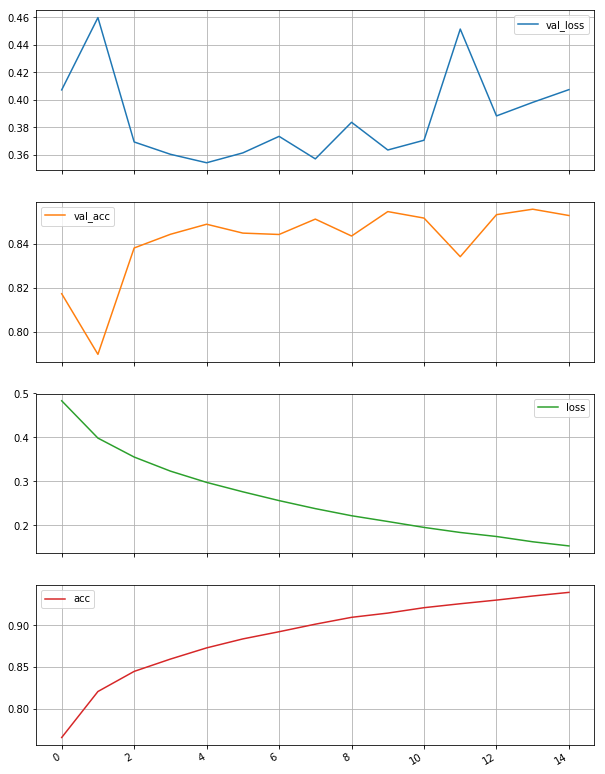

In [494]:
%matplotlib inline
df = pd.DataFrame(history.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

### Testing Accuracy

In [495]:
y = model.predict(TestData)
y = np.around(y)
correct = 0
wrong   = 0
j = 0
for i in TestDataAct:
    if y[j]==i:
        correct = correct + 1
        j = j + 1
    else:
        wrong = wrong + 1
        j = j + 1
print("Errors: " + str(wrong), " Correct :" + str(correct))

print("Testing Accuracy: " + str(correct/(correct+wrong)*100))

Errors: 2098  Correct :12207
Testing Accuracy: 85.33379937084935


## Code for Data Preprocessing

### Preprocessing

In [ ]:
'''
import csv

f1 = open('same_pairs.csv', 'r')
f2 = open('GSC-Features.csv', 'r')
f22 = open('GSC-Features.csv', 'r')
f3 = open('results-final.csv', 'w')
f4 = open('diffn_pairs_shu.csv', 'r')

c1 = csv.reader(f1)
c2 = csv.reader(f2)
c3 = csv.writer(f3)
c4 = csv.reader(f4)
c5 = csv.reader(f22)


masterlist = list(c2)
masterlist2 = list(c5)

row = 1
for hosts_row in c1:
    if(row==1):
    	row = 2
    	continue
    results=[]
    for master_row in masterlist:

        if hosts_row[0] == master_row[0]:
            results.append(master_row[1:513])
        if hosts_row[1] == master_row[0]:
        	results.append(master_row[1:513])
        
    results.append(hosts_row[2])
    list = [y for x in results for y in x]

    #print(list)
    c3.writerow(list)


row = 1

for hosts_row in c4:
	if(row>71532):
		break
		
	results=[]

	for master_row in masterlist2:
		if hosts_row[0] == master_row[0]:
			results.append(master_row[1:513])
		if hosts_row[1] == master_row[0]:
			results.append(master_row[1:513])
    
	results.append(hosts_row[2])
	list = [y for x in results for y in x]
	c3.writerow(list)
	row =row + 1
        


f1.close()
f2.close()
'''

### Shuffle Data

In [ ]:
'''
import numpy as np
import pandas as pd

def shuffler(filename):
  df = pd.read_csv(filename, header=0)
  # return the pandas dataframe
  return df.reindex(np.random.permutation(df.index))


def main(outputfilename):
  shuffler('final_results_sub.csv').to_csv(outputfilename, sep=',',header=0 , index=0)

if __name__ == '__main__': 
  main('final_sub.csv')
'''

### Detecting columns with all the values zero in GSC Dataset

In [ ]:
'''
import csv
import pandas as pd
import numpy as np

list = []
df = pd.DataFrame(data=[])
df = pd.read_csv('final-gsc-sub.csv')
#print(df)	
num = np.asarray(df)
print(num.shape)
row, col = num.shape
col = col - 2
print("Col",col)
for i in range(col):
	sum =0
	for j in range(row):
		sum = sum + num[j][i]
	if(sum==0):
		print("Column index",i,"is ZERO")
'''